In [1]:
import sys 
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path+"/python" not in sys.path:
    sys.path.append(module_path+"/python")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import observation as obs
import simulation as sim
from function import get_hetero, get_fst, calculate_ints, location, columns

In [2]:
def getIntervals(pop_ts, num_ind, max_sites, style):
    
    for obs_ind in num_ind:
        for obs_sites in max_sites:
            if style < 2:
                obs_ts = obs.Div(pop_ts, obs_ind, obs_sites)
            else:
                obs_ts = obs.Fst(pop_ts, obs_ind, obs_sites)
                
            if style==0:
                obs_ts_value = obs_ts.div
                
                resampled_sites = [obs_ts.bootstrap_sites_diversity(),
                                   obs_ts.jackknife_one_sites_diversity(),
                                   obs_ts.jackknife_mj_sites_diversity(n_block)]
                
                resampled_ind = [obs_ts.bootstrap_ind_diversity(),
                                obs_ts.jackknife_one_ind_diversity()]   
            elif style==1:
                obs_ts_value = obs_ts.hetero
                
                resampled_sites = [obs_ts.bootstrap_sites_hetero(),
                                   obs_ts.jackknife_one_sites_hetero(),
                                   obs_ts.jackknife_mj_sites_hetero(n_block)]
                
                resampled_ind = [obs_ts.bootstrap_ind_hetero(),
                                obs_ts.jackknife_one_ind_hetero()]
            else:
                obs_ts_value = obs_ts.fst
                
                resampled_sites = [obs_ts.bootstrap_sites_fst(),
                                   obs_ts.jackknife_one_sites_fst(),
                                   obs_ts.jackknife_mj_sites_fst(n_block)]
                
                resampled_ind = [obs_ts.bootstrap_ind_fst(),
                                obs_ts.jackknife_one_ind_fst()]

            # confidence intervals of resampling over sites for diversity
            sites = calculate_ints(resampled_sites, confidence, obs_ts_value)

            # confidence intervals of resampling over individuals for diversity
            ind = calculate_ints(resampled_ind, confidence, obs_ts_value)

            yield obs_ts_value, sites, ind
        

def intervalPlot(pop_ts, pop_ts_value, num_ind, max_sites, style):
    fig, ax1 = plt.subplots(figsize=(20, 8))
    
    # axis for constant line
    ax2 = ax1.twiny()
    ax2.axhline(pop_ts_value, color="deepskyblue", label="pop_value", ls="--")
    
    if style == 0:
        title = "Estimated Confidence Intervals of Site Diversity For Different Resampleing Methods"
    elif style == 1:
        title = "Estimated Confidence Intervals of Heterozygosity For Different Resampleing Methods"
    else:
        title = "Estimated Confidence Intervals of FST For Different Resampleing Methods"
        
    
    if len(num_ind) < len(max_sites):
        x = np.array(max_sites) // 1000
        lineLabel = max_sites
        xlabel = "Observed Number of Sites / 1000"
    else:
        x = np.array(num_ind) // 10
        lineLabel = num_ind
        xlabel = "Observed Number of Individuals / 10"
    
    for i, (obs_ts_value, sites, ind) in enumerate(getIntervals(pop_ts, num_ind, max_sites, style)):
        # draw the CI for each resampling method
        for j, (lower, upper) in enumerate(sites + ind):
            ax1.plot((x[i] + gap * j, x[i] + gap * j), (lower, upper), 'o-', color=intervalColor[j])   
            
        # draw an line for observed value 
        ax2.axhline(y=obs_ts_value, xmin=i / 3, xmax=(i + 1) / 3, color=lineColor[i], 
                    ls="--", label=f"obs_value_{lineLabel[i]}")

    ax1.legend(labels=labels, loc=9)
    ax1.set(ylabel='Confidence Interval', xlabel=xlabel)
    ax1.set_title(title)
    
    ax2.legend(loc=0)
    ax2.xaxis.set_ticks([])
    ax2.xaxis.set_ticklabels([])
    plt.show()

# Global variables

In [3]:
num_ind = [20, 50, 100]
max_sites = [5000, 20000, 50000]
confidence = 0.95
n_block = int(1e9 // 5e6)

intervalColor = ["red", "green", "blue", "purple", "black"]
lineColor = ["darkorange", "darkgrey", "brown"]
labels = ["bt_sites", "jk_one_sites", "jk_sites_mj", "bt_ind", "jk_ind"]

gap = 0.5

## Diversity and Heterozygosity

In [4]:
pop_ts = sim.sim_one_population(
        pop_ind=1000,
        seq_len=1e9,
        rec_rate=1e-8,
        mut_rate=1e-8,
    )

diversity = pop_ts.diversity(span_normalise=False, windows='sites').mean()
hetero = get_hetero(pop_ts)
print('Population num sites is:', pop_ts.num_sites)
print('Population site diversity:', diversity)
print('Population heterozygosity:', hetero)

Population num sites is: 329562
Population site diversity: 0.12035798379038533
Population heterozygosity: 0.12042820470806709


### Diversity

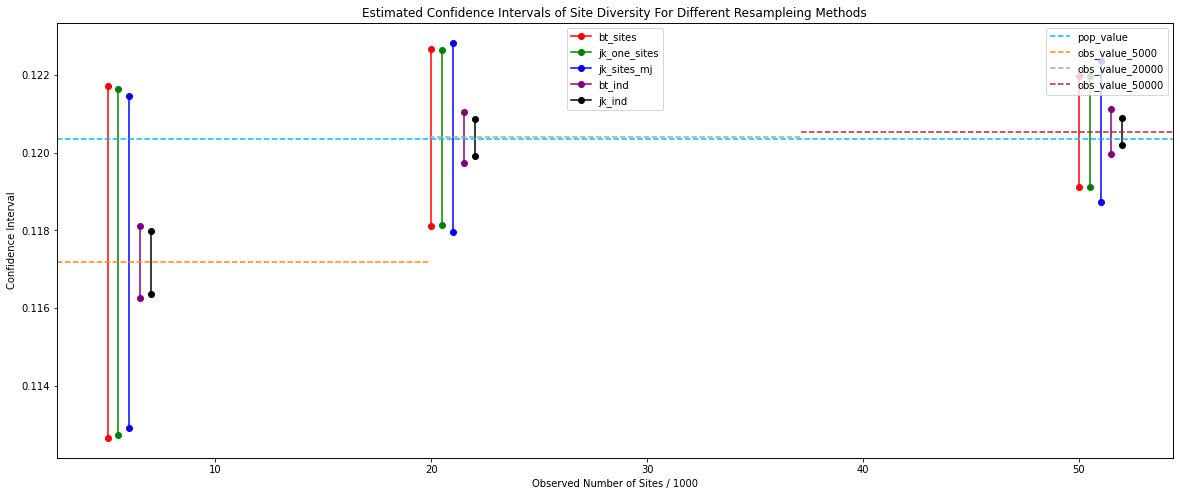

In [5]:
intervalPlot(pop_ts, diversity, num_ind=[50], max_sites=[5000, 20000, 50000], style=0)

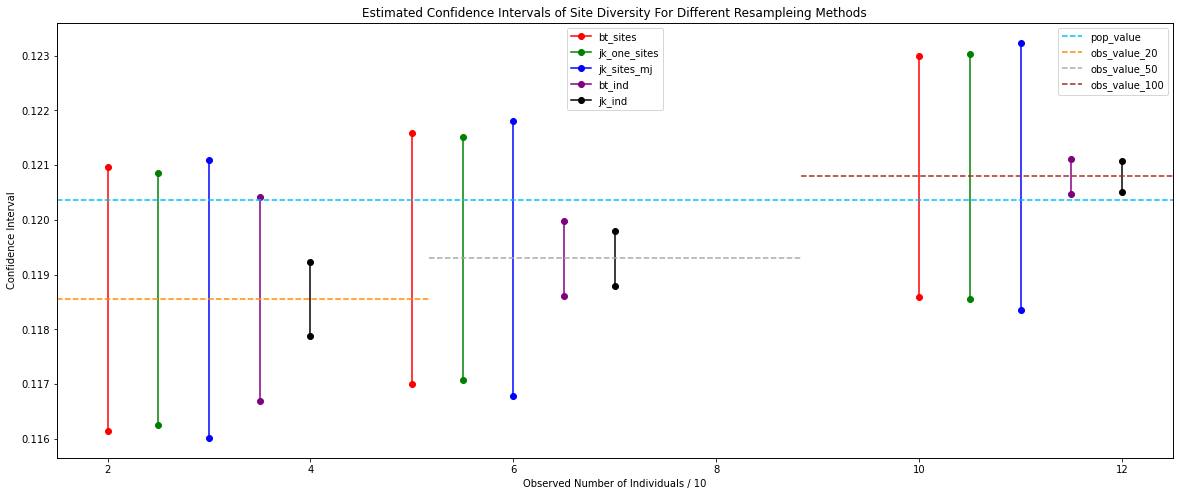

In [6]:
intervalPlot(pop_ts, diversity, num_ind=[20, 50, 100], max_sites=[20000], style=0)

### Heterozygosity

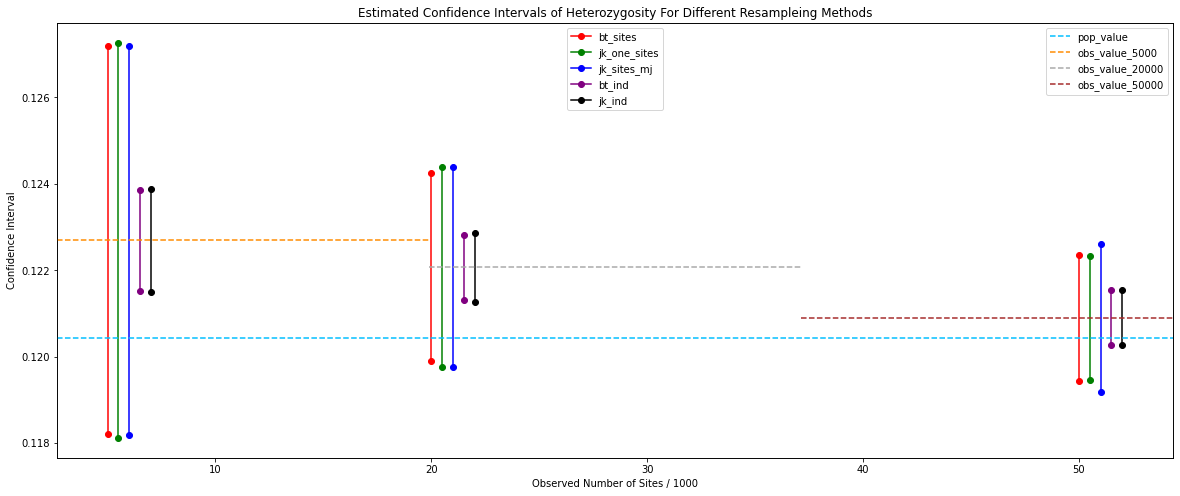

In [7]:
intervalPlot(pop_ts, hetero, num_ind=[50], max_sites=[5000, 20000, 50000], style=1)

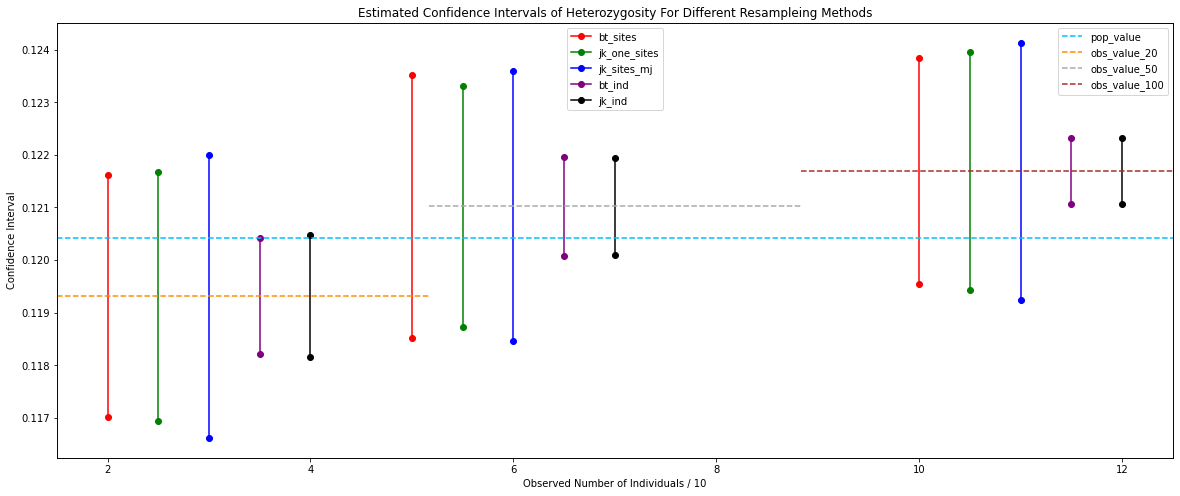

In [8]:
intervalPlot(pop_ts, hetero, num_ind=[20, 50, 100], max_sites=[20000], style=1)

### Fst

In [9]:
pop_ts_fst = sim.sim_population(
        pop_ind=1000,
        split_time=50,
        seq_len=1e9,
        rec_rate=1e-8,
        mut_rate=1e-8,
    )

fst = get_fst(pop_ts_fst)
print('Population num sites is:', pop_ts_fst.num_sites)
print('Population Fst:', fst)

Population num sites is: 223715
Population Fst: 0.024525191568956512


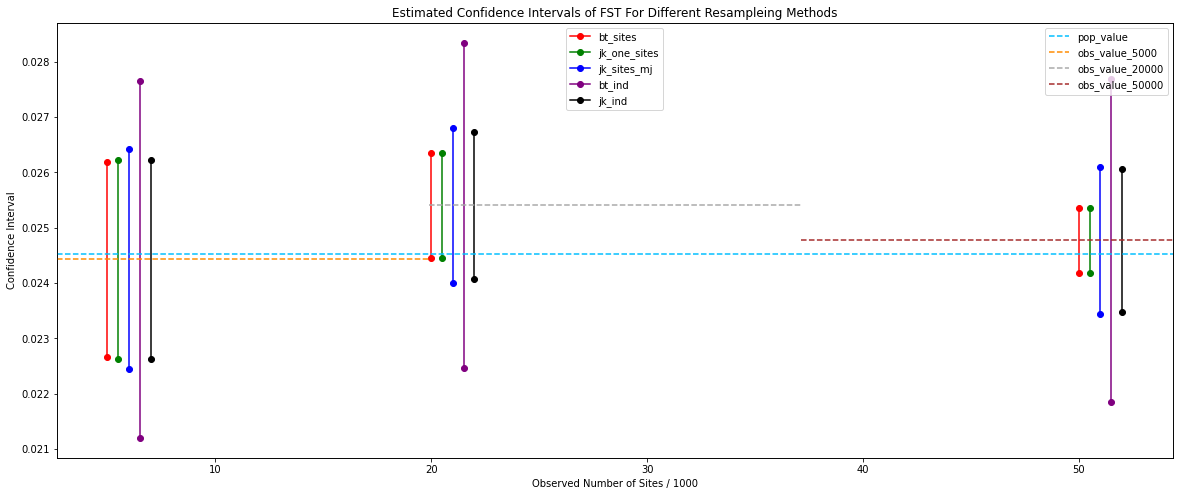

In [10]:
intervalPlot(pop_ts_fst, fst, num_ind=[50], max_sites=[5000, 20000, 50000], style=2)

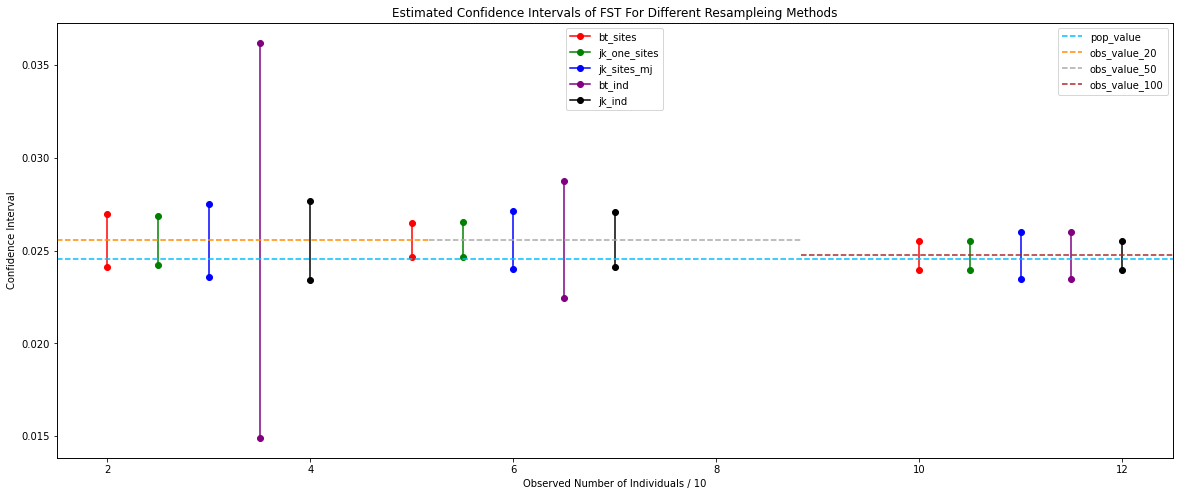

In [11]:
intervalPlot(pop_ts_fst, fst, num_ind=[20, 50, 100], max_sites=[20000], style=2)